In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.gluon.contrib import nn as nn_contrib

ctx = mx.gpu()

### Predict classes
- channel `i*(num_class+1)` store the scores for this box contains only background
- channel `i*(num_class+1)+1+j` store the scores for this box contains an object from the *j*-th class

In [2]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

### Predict anchor boxes
- $t_x = (Y_x - b_x) / b_{width}$
- $t_y = (Y_y - b_y) / b_{height}$
- $t_{width} = (Y_{width} - b_{width}) / b_{width}$
- $t_{height} = (Y_{height} - b_{height}) / b_{height}$

In [3]:
def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

### Manage preditions from multiple layers

In [4]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

### Body network

In [5]:
global alpha
from mxnet import gluon
alpha = 4
def s16():
    out = nn.HybridSequential()
    with out.name_scope():
        num_filter = 32/alpha
        num_filter_second = 96/alpha
        num_filter_third = 144/alpha
        linear_filter_one = 16/alpha
        linear_filter_second = 24/alpha
        # conv2d
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=2, padding=1, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_1_16_1
        out.add(nn.Conv2D(num_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_1_16_2
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_1_16_3
        out.add(nn.Conv2D(linear_filter_one, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        # bottleneck_1_24_1
        out.add(nn.Conv2D(num_filter_second, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_1_24_2
        out.add(nn.Conv2D(num_filter_second, kernel_size=3, strides=2, padding=1, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_1_24_3
        out.add(nn.Conv2D(linear_filter_second, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        # bottleneck_2_24_1
        out.add(nn.Conv2D(num_filter_third, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_2_24_2
        out.add(nn.Conv2D(num_filter_third, kernel_size=3, strides=1, padding=1, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_2_24_3
        out.add(nn.Conv2D(linear_filter_second, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        # bottleneck_1_32_1
        out.add(nn.Conv2D(num_filter_third, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_1_32_2
        out.add(nn.Conv2D(num_filter_third, kernel_size=3, strides=2, padding=1, use_bias=False))
    out.hybridize()
    #out.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
    #out.load_params('weights/sqnet_c7.params', ctx=ctx)
    return out        
        
def s32():
    out = nn.HybridSequential()
    with out.name_scope():
        num_filter_prv = 144/alpha
        num_filter = 192/alpha
        linear_filter = 32/alpha
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_1_32_3
        out.add(nn.Conv2D(linear_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        # bottleneck_2_32_1
        out.add(nn.Conv2D(num_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_2_32_2
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_2_32_3
        out.add(nn.Conv2D(linear_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        # bottleneck_3_32_1
        out.add(nn.Conv2D(num_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_3_32_2
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_3_32_3
        out.add(nn.Conv2D(linear_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        # bottleneck_1_64_1
        out.add(nn.Conv2D(num_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
        out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
        out.add(nn.Activation('relu'))
        # bottleneck_1_64_2
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=2, padding=1, use_bias=False))
    out.hybridize()
    #out.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
    #out.load_params('weights/sqnet_c7.params', ctx=ctx)
    return out

def b1():
    num_filter = 384/alpha
    linear_filter = 64/alpha
    out = nn.HybridSequential()
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # linear
    out.add(nn.Conv2D(linear_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    # expand
    out.add(nn.Conv2D(num_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # dwise
    out.add(nn.Conv2D(num_filter, kernel_size=3, strides=2, padding=1, use_bias=False))
    return out

def b2():
    num_filter = 384/alpha
    linear_filter = 64/alpha
    out = nn.HybridSequential()
    out.add(nn.BatchNorm(in_channels=num_filter, use_global_stats=True, epsilon=0.000100))
    out.add(nn.Activation('relu'))
    # linear
    out.add(nn.Conv2D(linear_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    # expand
    out.add(nn.Conv2D(num_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # dwise
    out.add(nn.Conv2D(num_filter, kernel_size=3, strides=2, padding=1, use_bias=False))
    return out

def b3():
    num_filter = 384/alpha
    linear_filter = 64/alpha
    out = nn.HybridSequential()
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # linear
    out.add(nn.Conv2D(linear_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    # expand
    out.add(nn.Conv2D(num_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # dwise
    out.add(nn.Conv2D(num_filter, kernel_size=3, strides=2, padding=1, use_bias=False))
    return out

def b4():
    num_filter = 394/alpha
    linear_filter = 64/alpha
    out = nn.HybridSequential()
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # linear
    out.add(nn.Conv2D(linear_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    # expand
    out.add(nn.Conv2D(num_filter, kernel_size=1, strides=1, padding=0, use_bias=False))
    out.add(nn.BatchNorm(use_global_stats=False, epsilon=1e-05, momentum=0.9, axis=1))
    out.add(nn.Activation('relu'))
    # dwise
    out.add(nn.Conv2D(num_filter, kernel_size=3, strides=2, padding=1, use_bias=False))
    return out

### Create an SSD model

In [6]:
def ssd_model(num_anchors, num_classes):
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()
    
    for scale in range(6):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))
    
    return s16(), s32(), b1(), b2(), b3(), b4(), class_preds, box_preds

### Forward

In [7]:
def ssd_forward(x, s16, s32, b1, b2, b3, b4, class_preds, box_preds, sizes, ratios):
    default_anchors = []
    predicted_boxes = []  
    predicted_classes = []

    for i in range(31):
        x = s16[i](x)
        if i == 18:
            conv2_2_linear_scale = x
        elif i == 26:
            x = mx.nd.broadcast_add(conv2_2_linear_scale, x)
    default_anchors.append(MultiBoxPrior(x, sizes=sizes[0], ratios=ratios[0]))
    predicted_boxes.append(flatten_prediction(box_preds[0](x)))
    predicted_classes.append(flatten_prediction(class_preds[0](x)))
    
    for i in range(24):
        x = s32[i](x)
        if i == 3:
            conv3_2_linear_scale = x
        elif i == 11:
            x = mx.nd.broadcast_add(conv3_2_linear_scale, x)
            block_4_1 = x
        elif i == 19:
            x = mx.nd.broadcast_add(block_4_1, x)
    default_anchors.append(MultiBoxPrior(x, sizes=sizes[1], ratios=ratios[1]))
    predicted_boxes.append(flatten_prediction(box_preds[1](x)))
    predicted_classes.append(flatten_prediction(class_preds[1](x)))
    
    x = b1(x)
    default_anchors.append(MultiBoxPrior(x, sizes=sizes[2], ratios=ratios[2]))
    predicted_boxes.append(flatten_prediction(box_preds[2](x)))
    predicted_classes.append(flatten_prediction(class_preds[2](x)))
    
    x = b2(x)
    default_anchors.append(MultiBoxPrior(x, sizes=sizes[3], ratios=ratios[3]))
    predicted_boxes.append(flatten_prediction(box_preds[3](x)))
    predicted_classes.append(flatten_prediction(class_preds[3](x)))
    
    x = b3(x)
    default_anchors.append(MultiBoxPrior(x, sizes=sizes[4], ratios=ratios[4]))
    predicted_boxes.append(flatten_prediction(box_preds[4](x)))
    predicted_classes.append(flatten_prediction(class_preds[4](x)))
    
    x = b4(x)
    default_anchors.append(MultiBoxPrior(x, sizes=sizes[5], ratios=ratios[5]))
    predicted_boxes.append(flatten_prediction(box_preds[5](x)))
    predicted_classes.append(flatten_prediction(class_preds[5](x)))

    return default_anchors, predicted_classes, predicted_boxes

### Put all things together

In [8]:
from mxnet import gluon
class SSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.anchor_sizes = [[0.04, 0.1],[0.1,0.26],[0.26,0.42],[0.42,0.58],[0.58,0.74],[0.74,0.9],[0.9,1.06]]
        self.anchor_ratios = [[1, 2, .5]] * 6
        self.num_classes = num_classes

        with self.name_scope():
            self.s16, self.s32, self.b1, self.b2, self.b3, self.b4, self.class_preds, self.box_preds = ssd_model(4, num_classes)
            
    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = ssd_forward(x, self.s16, self.s32, self.b1, self.b2, self.b3, self.b4,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))
        
        return anchors, class_preds, box_preds

### Outputs of SSD

In [9]:
net = SSD(2)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
#net.load_parameters("process/ssd_100.params",ctx=ctx)
x = nd.zeros((1, 3, 512, 512),ctx=ctx)
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)

('Outputs:', 'anchors', (1L, 21840L, 4L), 'class prediction', (1L, 21840L, 3L), 'box prediction', (1L, 87360L))


### Load dataset

In [10]:
from source.NACDDetection import NACDDetection

train_dataset = NACDDetection(splits=[('NACDwNegswAugCropped', 'train')])
test_dataset = NACDDetection(splits=[('NACDwNegswAugCropped', 'test')])

print('Training images:', len(train_dataset))
print('Test images:', len(test_dataset))

('Training images:', 10854)
('Test images:', 1488)


In [11]:
from source import NACDTransform
width, height = 512, 512
train_transform = NACDTransform.NACDDefaultTransform(width, height, False)
test_transform = NACDTransform.NACDDefaultTransform(width, height, True)

In [12]:
from gluoncv.data.transforms import presets
from gluoncv import utils
from mxnet import nd
from matplotlib import pyplot as plt
from gluoncv.utils import viz

In [13]:
train_image, train_label = test_dataset[0]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

('image:', (650L, 650L, 3L))
('bboxes:', (4, 4), 'class ids:', (4, 1))


In [14]:
train_image2, train_label2 = train_transform(train_image, train_label)
print('tensor shape:', train_image2.shape)

('tensor shape:', (3L, 512L, 512L))


In [15]:
from gluoncv.data.batchify import Tuple, Stack, Pad
from mxnet.gluon.data import DataLoader

batch_size = 16
num_workers = 4

batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
test_loader = DataLoader(test_dataset.transform(test_transform), batch_size, shuffle=False,
                        batchify_fn=batchify_fn, last_batch='keep', num_workers=num_workers)

for ib, batch in enumerate(test_loader):
    if ib > 3:
        break
    print('data:', batch[0].shape, 'label:', batch[1].shape)

('data:', (16L, 3L, 512L, 512L), 'label:', (16L, 4L, 6L))
('data:', (16L, 3L, 512L, 512L), 'label:', (16L, 8L, 6L))
('data:', (16L, 3L, 512L, 512L), 'label:', (16L, 10L, 6L))
('data:', (16L, 3L, 512L, 512L), 'label:', (16L, 6L, 6L))


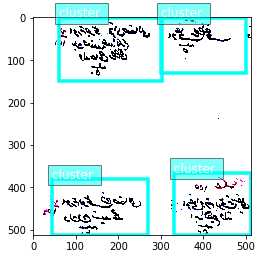

In [16]:
train_image2 = train_image2.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
train_image2 = (train_image2 * 255).clip(0, 255)
ax = viz.plot_bbox(train_image2.asnumpy(), train_label2[:, :4],
                   labels=train_label2[:, 4:5],
                   class_names=train_dataset.classes)
plt.show()

## Train

In [17]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(anchor=default_anchors.as_in_context(mx.cpu()), label=labels.as_in_context(mx.cpu()), cls_pred=class_predicts.as_in_context(mx.cpu()))
    box_target = z[0].as_in_context(ctx)  # box offset target for (x, y, width, height)
    box_mask = z[1].as_in_context(ctx)  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2].as_in_context(ctx)  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [18]:
def convertlbl(y):
    mtrx = y[:,:,0:4]
    mtrx = mtrx.asnumpy()
    mtrx[mtrx == -1] = -width
    mtrx = mtrx/512
    return mx.nd.concat(nd.expand_dims(y[:,:,4],2),mx.nd.array(mtrx),dim=2)

In [19]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma
    
    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)

FocalLoss(batch_axis=0, w=None)


In [20]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
    
    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


### Initialize parameters

In [21]:
import time
from mxnet import autograd as ag
from gluoncv.loss import SSDMultiBoxLoss

In [22]:
# loop params
epochs = 200
start_epoch = 1

# initialize trainer
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 1e-1, 'wd': 4e-5})

# evaluation metrics
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()
cls_metric_test = mx.metric.Accuracy()
box_metric_test = mx.metric.MAE()

# training loop
for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    #train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    train_loss = 0
    # iterate through all batch
    for i, batch in enumerate(train_loader):
        # record gradients
        with ag.record():
            x = batch[0].as_in_context(ctx)
            y = batch[1].as_in_context(ctx)
            lbl = convertlbl(batch[1])
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, lbl)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            train_loss += nd.sum(loss).asscalar()
            # backpropagate
            loss.backward()
        # apply 
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        #if (i + 1) % log_interval == 0:
    toc = time.time()
    name1_train, val1_train = cls_metric.get()
    name2_train, val2_train = box_metric.get()

    cls_metric_test.reset()
    box_metric_test.reset()
    tic = time.time()
    test_loss = 0
    for i, batch in enumerate(test_loader):
        # record gradients
        x = batch[0].as_in_context(ctx)
        y = batch[1].as_in_context(ctx)
        lbl = convertlbl(batch[1])
        default_anchors, class_predictions, box_predictions = net(x)
        box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, lbl)
        # losses
        loss1 = cls_loss(class_predictions, cls_target)
        loss2 = box_loss(box_predictions, box_target, box_mask)
        # sum all losses
        loss = loss1 + loss2
        test_loss += nd.sum(loss).asscalar()
        # update metrics
        cls_metric_test.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric_test.update([box_target], [box_predictions * box_mask])
        #if (i + 1) % log_interval == 0:
    toc = time.time()
    name1_test, val1_test = cls_metric_test.get()
    name2_test, val2_test = box_metric_test.get()
    print('epoch:%3d;\t train:%.6e;%f;%.6e;\t test:%.6e;%f;%.6e'
          %(epoch, train_loss/len(train_dataset), val1_train, val2_train, test_loss/len(test_dataset), val1_test, val2_test))

    net.save_parameters('process/ssd_%d.params' % epoch)

epoch:  1;	 train:5.324181e-03;0.991906;2.067352e-03;	 test:2.591224e-03;0.996757;1.922508e-03
epoch:  2;	 train:3.236362e-03;0.997087;2.007160e-03;	 test:2.412112e-03;0.997530;1.891264e-03
epoch:  3;	 train:3.000495e-03;0.997656;1.971673e-03;	 test:2.322362e-03;0.997785;1.886420e-03
epoch:  4;	 train:2.786469e-03;0.997770;1.952045e-03;	 test:2.230651e-03;0.997815;1.877235e-03
epoch:  5;	 train:2.655004e-03;0.997794;1.931696e-03;	 test:2.184055e-03;0.997845;1.849026e-03
epoch:  6;	 train:2.569443e-03;0.997810;1.934809e-03;	 test:2.119953e-03;0.997906;1.851332e-03
epoch:  7;	 train:2.505768e-03;0.997863;1.917984e-03;	 test:2.119484e-03;0.997950;1.861915e-03
epoch:  8;	 train:2.469420e-03;0.997900;1.922750e-03;	 test:2.070966e-03;0.997943;1.863940e-03
epoch:  9;	 train:2.424883e-03;0.997937;1.902760e-03;	 test:2.031557e-03;0.997966;1.846208e-03
epoch: 10;	 train:2.394634e-03;0.997945;1.903899e-03;	 test:2.020531e-03;0.998020;1.834323e-03
epoch: 11;	 train:2.346042e-03;0.997977;1.900567e-

epoch: 88;	 train:1.870423e-03;0.998158;1.793798e-03;	 test:1.564761e-03;0.998228;1.691599e-03


Process Process-710:
Process Process-712:
Process Process-709:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/mxnet/gluon/data/dataloader.py", line 116, in worker_loop
    idx, samples = key_queue.get()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 115, in get
    self._target(*self._args, **self._kwargs)
    self._rlock.acquire()
  File "/usr/local/lib/python2.7/dist-packages/mxnet/gluon/data/dataloader.py", line 116, in worker_loop
KeyboardInterrupt
    idx, samples = key_queue.get()
  File "/usr/lib/python2.7/multiprocessing/

KeyboardInterrupt: 

## Test

### Prepare the test data

In [39]:
test_image, test_label = test_dataset[0]
test_image2, test_label2 = test_transform(test_image, test_label)
test_image2 = nd.expand_dims(test_image2,0)
print('tensor shape:', test_image2.shape)

('tensor shape:', (1L, 3L, 512L, 512L))


### Network inference

In [40]:
anchors, cls_preds, box_preds = net(test_image2.as_in_context(ctx))

### Convert predictions to real object detection results

In [41]:
from mxnet.contrib.ndarray import MultiBoxDetection
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
output = MultiBoxDetection(cls_prob=cls_probs, loc_pred=box_preds, anchor=anchors, force_suppress=True, clip=True, nms_topk=250)

### Display results

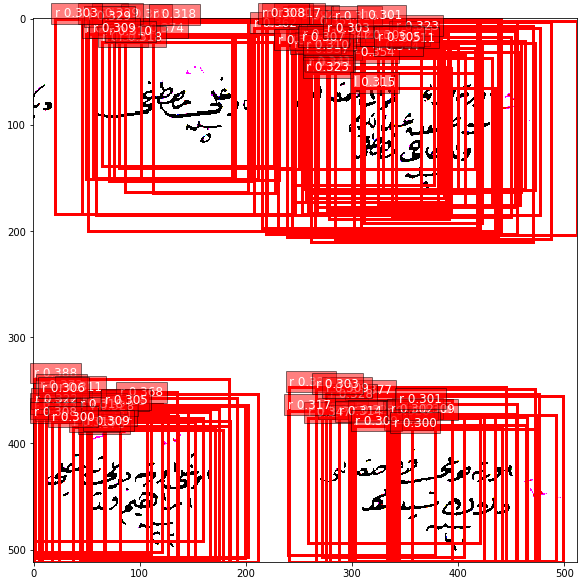

In [42]:
class_names = ('cluster')
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    import numpy as np
    mpl.rcParams['figure.figsize'] = (10,10)
    img = img.asnumpy()
    img = np.transpose(img,(2,3,1,0))
    img = np.squeeze(img)
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid == 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor='red', linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor='red', alpha=0.5),
                       fontsize=12, color='white')

display(test_image2, output[0].asnumpy(), thresh=0.3)